In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.date_dayfirst", True)
pd.set_option("display.date_yearfirst", False)
#pd.describe_option('display.date_yearfirst')
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.mlab as mlab

import matplotlib.pylab as pylab

import os
cwd = os.getcwd()

#Import excel file into pandas dataframe

In [34]:
#mainpath = 'C:/Users/mb22/OneDrive/PhD/Quasar Shared/'
#filepath = 'Data/NPL_Table_All.xlsx'
filepath = 'Data to Import/All_Ext_OPs-Jan-Jun2015 - Anon 20Oct15.xlsx'

#fullpath=mainpath+filepath
fullpath=cwd+'/'+filepath # use if need to specify full path for some reason.
print(fullpath) #note forward and backward slashes in output

all_data = pd.read_excel(filepath, parse_dates=['Date'])
all_data.head(5)
#all_data.describe()

C:\Users\mb22\OneDrive\PhD\Quasar Shared\Modelling\IPython/Data to Import/All_Ext_OPs-Jan-Jun2015 - Anon 20Oct15.xlsx


,Centre_ID,Group,Linac_Manufacturer,Linac_Model,Linac_Install_Date,Linac_ID,Date,Measurement_Device,OP_Dif,Recording,Comments
0,10,1,Varian,Clinac 2100iX,2007,62,2015-03-26,BeamChecker,3.3,Daily is Dose Checker then transferred to spre...,NaN
1,10,1,Varian,Clinac 2100iX,2007,62,2015-05-06,BeamChecker,3.3,Daily is Dose Checker then transferred to spre...,NaN
2,10,1,Varian,Clinac 2100iX,2007,62,2015-06-17,BeamChecker,3.3,Daily is Dose Checker then transferred to spre...,NaN
3,10,1,Varian,Clinac 2100iX,2007,62,2015-06-21,BeamChecker,3.2,Daily is Dose Checker then transferred to spre...,NaN
4,10,1,Varian,Clinac 2100iX,2007,61,2015-05-27,BeamChecker,3.1,Daily is Dose Checker then transferred to spre...,NaN


#Calculate some stats & check data types

In [35]:
mean = np.mean(all_data['OP_Dif'])
sd = np.std(all_data['OP_Dif'])
all_data.describe()
#all_data.dtypes

#all_data.groupby(['Type'])['Energy'].nunique().reset_index() # number of unique dates = number of visits

,Centre_ID,Group,Linac_Install_Date,Linac_ID,OP_Dif
count,11564.000000,11564.000000,8772.000000,11564.000000,11564.000000
mean,7.711086,4.344431,2007.673735,47.018938,-0.009187
std,4.622100,2.720436,3.641816,27.162636,0.882721
min,1.000000,1.000000,2000.000000,1.000000,-4.200000
25%,3.000000,1.000000,2006.000000,21.000000,-0.600000
50%,9.000000,4.000000,2007.000000,51.000000,0.000000
75%,11.000000,6.000000,2010.000000,68.250000,0.569004
max,16.000000,9.000000,2015.000000,94.000000,3.300000


#Make some quick graphs

### Plot of each centres distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0FF7D690>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11773970>]], dtype=object)

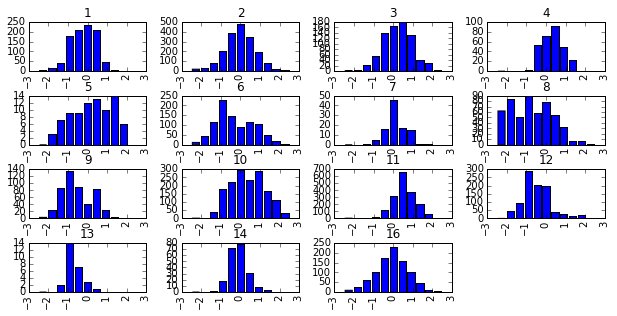

In [36]:
from decimal import * # decimal means that more exact maths can be done with a specified precision.
getcontext().prec = 28
range_lower = Decimal('-2.5')
range_upper = Decimal('2.5')
bin_width = Decimal('0.005')
number_bins = (range_upper-range_lower)/bin_width + 1

## Linac Manufacturer
#all_data['OP_Dif'].hist(by=all_data['Linac_Manufacturer'], normed=False, bins=11, range=(-2.5,2.5), rwidth=0.8)
#plt.savefig('OPs/All_Hist_Manufacturer.png', bbox_inches='tight', dpi=300)

## Linac Model
#all_data['OP_Dif'].hist(by=all_data['Linac_Model'], normed=False, bins=11, range=(-2.5,2.5), rwidth=0.8)
#plt.savefig('OPs/All_Hist_Model.png', bbox_inches='tight', dpi=300)

## Centre
all_data['OP_Dif'].hist(by=all_data['Centre_ID'], normed=False, bins=11, range=(-2.5,2.5), rwidth=0.8)
#plt.savefig('OPs/All_Hist_Centre.png', bbox_inches='tight', dpi=300)

## All Data
#all_data['OP_Dif'].hist(normed=False, bins=17, range=(-2.5,2.5), rwidth=1)
#plt.savefig('OPs/All_Hist.png', bbox_inches='tight', dpi=300)



#Histograms

##Ideally make into a function and feed data frame, title, filename

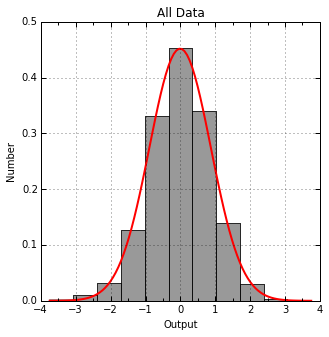

In [37]:
pylab.rcParams['figure.figsize'] = 5, 5 # change size of figures

from matplotlib.ticker import AutoMinorLocator

fig = plt.figure()
axes = fig.add_subplot(1,1,1)
plt.title('All Data')
plt.xlabel("Output")
plt.ylabel("Number")
#plt.xlim(-3.2, +3.2)
#plt.ylim(0, 60)

all_data['OP_Dif'].hist(bins=11, range=(-3.75, 3.75), normed=True,
                               facecolor = 'grey', alpha = 0.8, ax=axes, rwidth=1)

axes.xaxis.set_minor_locator(AutoMinorLocator(2)) #used to set the number of minor ticks between major ticks
plt.tick_params(which='major', width=1, length=5)
plt.tick_params(which='minor', width=1, length=3)
plt.grid(True, which='major')

mean = all_data['OP_Dif'].mean()
sd = all_data['OP_Dif'].std() # need to exclude outliers for this to be a useful calculation.

x = np.linspace(-3.75, 3.75, 100) # add normal distibution fit
plt.plot(x, mlab.normpdf(x,mean,sd), linewidth = 2, color='red')

#plt.savefig('OPs/All_Hist.png', bbox_inches='tight', dpi=300)

#Get some more stats such as Mean, SD, Skew etc.

In [38]:
print('Skew: ', all_data['OP_Dif'].skew())
print('SEM: ', all_data['OP_Dif'].sem())
print('Mean: ', all_data['OP_Dif'].mean())
print('SD: ', all_data['OP_Dif'].std()) # Need to remove outliers for useful stats

from scipy import stats
print('Skew Test: ', stats.skewtest(all_data['OP_Dif']))
#print('Norm Test: ', stats.mstats.normaltest(all_data['OP_Dif']))


Skew:  -0.175645927408
SEM:  0.00820860993729
Mean:  -0.00918660144143
SD:  0.88272141042
Skew Test:  (-7.6569216893507397, 1.9044267843761256e-14)


#Plot of All Audits

In [39]:
# Calculate rolling SD of 20 values

all_data_datesort = all_data.sort(['Date'], ascending=True)

all_data_datesort['SD_Prev100'] = np.nan
all_data_datesort['SD_Prev100'] = pd.rolling_std(all_data_datesort['OP_Dif'],window=200)

all_data_datesort.tail()


,Centre_ID,Group,Linac_Manufacturer,Linac_Model,Linac_Install_Date,Linac_ID,Date,Measurement_Device,OP_Dif,Recording,Comments,SD_Prev100
2880,3,6,Varian,Clinac iX,NaN,23,2015-06-30,Linacheck,0.570776,Paper,Weekly data provided. Daily is diodes in persp...,0.838717
2868,3,6,Varian,TrueBeam,NaN,26,2015-06-30,Linacheck,0.575374,Paper,Weekly data provided. Daily is diodes in persp...,0.834975
4953,16,3,Elekta,Elekta Beam Modulator,2006,93,2015-06-30,Sun Nuclear Checkmate,0.200000,Spreadsheets,NaN,0.830147
10477,6,3,Varian,2100CD,2007,38,2015-06-30,Linacheck,-1.133333,Paper + Copy to Spreadsheet,NaN,0.832067
2224,16,3,Elekta,Elekta Beam Modulator,2007,94,2015-06-30,Sun Nuclear Checkmate,0.750000,Spreadsheets,Daily Results Given,0.832008


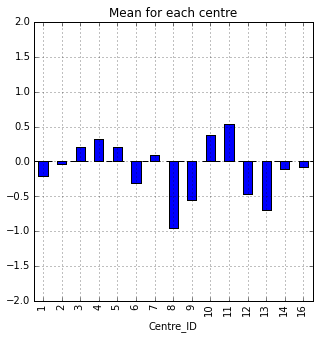

In [40]:
m = all_data_datesort
g = m.groupby('Centre_ID')
gmean = g.mean()
myplot = gmean['OP_Dif'].plot(kind='bar')
plt.ylim(-2,2)
plt.title("Mean for each centre")

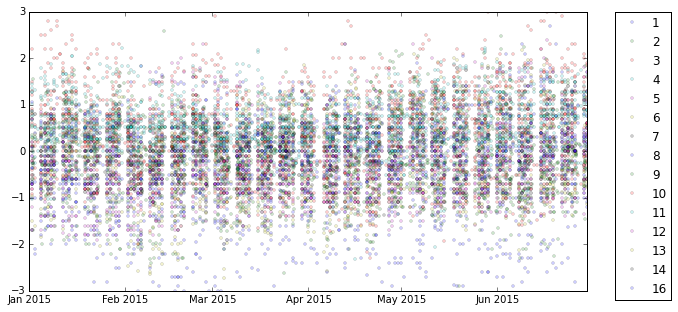

In [43]:
pylab.rcParams['figure.figsize'] = 10, 5 # change size of figures
#fig1 = plt.figure()
#axes1 = fig1.add_subplot(1,1,1)
#plt.title('Machine Output Variation')
#plt.xlabel("Date")
#plt.ylabel("Measured Output")
#plt.ylim(-4, 4)
#axes1.xaxis.set_minor_locator(AutoMinorLocator(4)) #used to set the number of minor ticks between major ticks
#plt.tick_params(which='major', width=1, length=5)
#plt.tick_params(which='minor', width=1, length=3)
#plt.grid(True, which='major')

#print(max(m['Centre_ID']))
#m.values
#mark_colors = np.array(m['Centre_ID'])
#print(mark_colors)

#x=np.arange(1,m['OP_Dif'].count()+1)
x=m['Date']
y=m['OP_Dif']

##This just plots all as the same colour
#plt.plot_date(x, y, alpha=0.4, color='b')
#yerr=(m['OPError']*m['OPRatio'])/100

##The below plots each centre as a different colour
df = pd.DataFrame(dict(x=m['Date'],y=m['OP_Dif'],label=m['Centre_ID']))

groups = df.groupby('label')

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot_date(group.x,group.y,label=name, alpha=0.2, ms=3)
#ax.legend(loc='best')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., numpoints=1)
plt.ylim(-3,3)
#plt.show()

ysd=m['SD_Prev100']

#plt.savefig('OPs/All_date_scatter_group_by_centre.png', bbox_inches='tight', dpi=300)

##Want to change the colour for a centre to make it clearer? Loop through each and give a colour? or create seperate sets fo data to plot?

Want to do the below with it split into groups, and also split into 5 year periods to see the variation with time. (Similar to Palmer paper...)

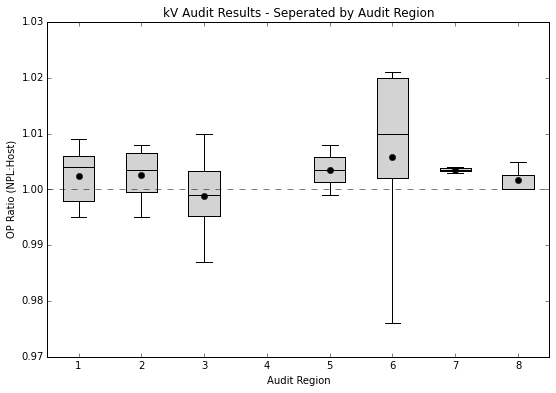

In [97]:
# extract only Groups and OPRatio to allow simple box plot production 
#mv = mv_data_datesort[['Group', 'OPRatio']]

# make a numpy array to use rather than pandas?
#g = np.array(mv_data_datesort['Group'])
#op = np.array(mv_data_datesort['OPRatio'])

#m = mv_data_datesort

g1 = k.loc[kv_data_datesort['Group']==1, ['OPRatio']]
g2 = k.loc[kv_data_datesort['Group']==2, ['OPRatio']]
g3 = k.loc[kv_data_datesort['Group']==3, ['OPRatio']]
g4 = k.loc[kv_data_datesort['Group']==4, ['OPRatio']]
g5 = k.loc[kv_data_datesort['Group']==6, ['OPRatio']]
g6 = k.loc[kv_data_datesort['Group']==7, ['OPRatio']]
g7 = k.loc[kv_data_datesort['Group']==8, ['OPRatio']]
g8 = k.loc[kv_data_datesort['Group']==9, ['OPRatio']]

grouped=[g1,g2,g3,g4,g5,g6,g7,g8] # this should be able to be done a bit easier without splitting it all up first.

fig = plt.figure(1, figsize=(9,6))

ax = fig.add_subplot(111)

bp = ax.boxplot(grouped, whis='range', patch_artist=True, showmeans=True)
plt.plot([-1,10],[1,1], linestyle='--', color='black', alpha=0.5) #add line at OPRatio=1
plt.title('kV Audit Results - Seperated by Audit Region')
plt.xlabel("Audit Region")
plt.ylabel("OP Ratio (NPL:Host)")
plt.ylim(0.97,1.03)

for box in bp['boxes']:
    box.set(facecolor='lightgrey')
    
for whisker in bp['whiskers']:
    whisker.set(linestyle='-', color='black') 
    
for median in bp['medians']:
    median.set(color='black')
    
for mean in bp['means']:
    mean.set(marker='o', color='black', markerfacecolor='black')
    
#plt.savefig('NPL_Paper_Plots/NPL_kV_All_Groups_NHS.png', bbox_inches='tight', dpi=300)


Plot all groups OP data as a sort of scatter plot (rather than use box plot?)

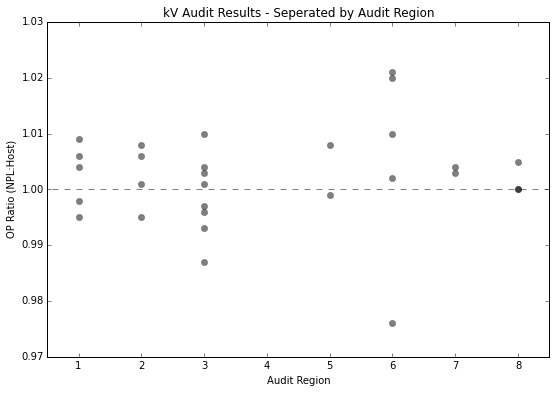

In [92]:
fig = plt.figure(1, figsize=(9,6))

ax = fig.add_subplot(111)
ax.set_xticks([1,2,3,4,5,6,7,8])

one = plt.plot([0,10],[1,1], '--', color='black', alpha=0.5) #add line for OPratio=1

for i in range(0, len(grouped)):
    scat = plt.plot(np.linspace(i+1,i+1,len(grouped[i])), grouped[i], u'o', color='black', alpha=0.5, linewidth=2)

plt.xlim(0.5,8.5)
plt.ylim(0.97,1.03)
plt.title('kV Audit Results - Seperated by Audit Region')
plt.xlabel("Audit Region")
plt.ylabel("OP Ratio (NPL:Host)")

##### can add box plot over the top by uncommenting the below line

#bp = ax.boxplot(grouped, whis='range', patch_artist=True, showmeans=True)

for box in bp['boxes']:
    box.set(facecolor='grey')
    
for whisker in bp['whiskers']:
    whisker.set(linestyle='-', color='black') 
    
for median in bp['medians']:
    median.set(color='black')
    
for mean in bp['means']:
    mean.set(marker='o', color='black', markerfacecolor='black')
    
#plt.savefig('NPL_Paper_Plots/NPL_kV_All_Groups_Scat_NHS.png', bbox_inches='tight', dpi=300)

   #Split data into 2 year intervals

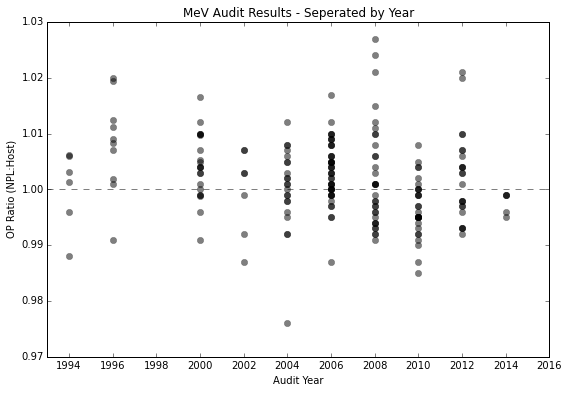

In [23]:
#create different sets of data containing 2 year intervals

d = nhs_data

y1 = d[(d['Date'] > '1994-01-01') & (d['Date'] < '1996-01-01')].copy()
y2 = d[(d['Date'] > '1996-01-01') & (d['Date'] < '1998-01-01')].copy()
y3 = d[(d['Date'] > '1998-01-01') & (d['Date'] < '2000-01-01')].copy()
y4 = d[(d['Date'] > '2000-01-01') & (d['Date'] < '2002-01-01')].copy()
y5 = d[(d['Date'] > '2002-01-01') & (d['Date'] < '2004-01-01')].copy()
y6 = d[(d['Date'] > '2004-01-01') & (d['Date'] < '2006-01-01')].copy()
y7 = d[(d['Date'] > '2006-01-01') & (d['Date'] < '2008-01-01')].copy()
y8 = d[(d['Date'] > '2008-01-01') & (d['Date'] < '2010-01-01')].copy()
y9 = d[(d['Date'] > '2010-01-01') & (d['Date'] < '2012-01-01')].copy()
y10 = d[(d['Date'] > '2012-01-01') & (d['Date'] < '2014-01-01')].copy()
y11 = d[(d['Date'] > '2014-01-01') & (d['Date'] < '2016-01-01')].copy()

#y1['GroupYear'] = 1
#y2['GroupYear'] = 2
#y3['GroupYear'] = 3
#y4['GroupYear'] = 4
#y5['GroupYear'] = 5
#y6['GroupYear'] = 6
#y7['GroupYear'] = 7
#y8['GroupYear'] = 8
#y9['GroupYear'] = 9
#y10['GroupYear'] = 10
#y11['GroupYear'] = 11

y1 = y1['OPRatio']
y2 = y2['OPRatio']
y3 = y3['OPRatio']
y4 = y4['OPRatio']
y5 = y5['OPRatio']
y6 = y6['OPRatio']
y7 = y7['OPRatio']
y8 = y8['OPRatio']
y9 = y9['OPRatio']
y10 = y10['OPRatio']
y11 = y11['OPRatio']

grouped_year=[y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11] # this should be able to be done a bit easier without splitting it all up first.

fig = plt.figure(1, figsize=(9,6))

ax = fig.add_subplot(111)
#ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11])
ax.set_xticks([1994,1996,1998,2000,2002,2004,2006,2008,2010,2012,2014,2016])

one = plt.plot([0,3000],[1,1], '--', color='black', alpha=0.5) #add line for OPratio=1

for i in range(0, len(grouped_year)):
    #print(i)
    scat = plt.plot(np.linspace(2*i+1994,2*i+1994,len(grouped_year[i])), grouped_year[i], u'o', color='black', alpha=0.5, linewidth=2)

#for i in range(0, len(grouped_year)):
#    print(np.linspace(i+1, i+1, len(grouped_year[i])))

#plt.xlim(0.5,11.5)
plt.xlim(1993, 2016)
plt.ylim(0.97,1.03)
plt.title('MeV Audit Results - Seperated by Year')
plt.xlabel("Audit Year")
plt.ylabel("OP Ratio (NPL:Host)")

#plt.savefig('NPL_Paper_Plots/NPL_kV_Years_Scat_NHS.png', bbox_inches='tight', dpi=300)
